In [21]:
import Config as C
import numpy as np
np.random.seed(C.SEED)
import random
random.seed(C.SEED)
from RewardFnSpace import *
import pickle
import more_itertools
from AcrobotUtils import *
from scipy.spatial.distance import pdist, squareform
import os
import os.path as osp
from A2C import *
from PlotUtils import *
from Eval import *
from rlpyt.samplers.serial.sampler import SerialSampler
from rlpyt.samplers.parallel.gpu.sampler import GpuSampler
from datetime import datetime

In [2]:

def findSamplesInTrajs (stateSamples, trajs) : 
    """ 
    For each state sample, find all indices (i, j) such that
    the jth state in ith trajectory is approximately the state
    sample
    """
    nSamples = stateSamples.shape[0]
    stateOccurenceIndices = [[] for _ in range(nSamples)]
    allStates = [np.stack([s for s, _, _ in t]) for t in trajs]
    for i, traj in enumerate(trajs) : 
        trajLen = len(traj)
        D = squareform(pdist(np.concatenate((stateSamples, allStates[i]), axis=0)))
        D = D[:nSamples, nSamples:]
        indices = np.where(D < C.STATE_SIMILARITY_THRESH)
        for j, k  in zip(*indices) : 
            stateOccurenceIndices[j].append((i, k))
    return stateOccurenceIndices


In [3]:
def generateStateSamples (trajs, nSamples) : 
    """ get the distribution of start states """
    allStates = [[s for s, _, _ in t] for t in trajs[:10]]
    allStates = list(more_itertools.flatten(allStates))
    states = random.sample(allStates, k=nSamples)
    states = np.array(states)
    return states

In [4]:
def estimateValueFromTrajs (stateIndices, trajs, rewardFn) :
    """ 
    Estimate the value for each state from expert 
    trajectories.
    """
    def computeReturnOnTraj (traj) : 
        R = [rewardFn(s) for s, _, _ in traj]
        return computeReturns(R, C.DISCOUNT)[0]
    values = []
    for i, indices in enumerate(stateIndices) : 
        truncatedTrajs = [trajs[i][j:] for i, j in indices] 
        vhat = np.mean([computeReturnOnTraj(t) for t in truncatedTrajs])
        values.append(vhat)
    return values

In [5]:
def estimateValueFromAgent (stateSamples, agent, rewardFn) : 
    """
    Use the learnt value function network through
    A2C to estimate value for states.
    """
    def estimateForState (s) : 
        cpus = list(range(C.N_PARALLEL))
        affinity = dict(cuda_idx=C.CUDA_IDX, workers_cpus=cpus)
        agent_ = CategoricalPgAgent(
            AcrobotNet, 
            initial_model_state_dict=agent.state_dict())
        sampler = SerialSampler(
            EnvCls=rlpyt_make,
            env_kwargs=dict(
                id=C.ENV, 
                reward=rewardFn, 
                internalStateFn=C.INTERNAL_STATE_FN, 
                s0=s),
            batch_T=C.HORIZON,
            batch_B=C.BATCH_B,
            max_decorrelation_steps=0,
        )
        sampler.initialize(
            agent=agent_,
            affinity=affinity,
            seed=C.SEED
        )
        _, traj_info = sampler.obtain_samples(0)
        returns = [t['DiscountedReturn'] for t in traj_info]
        return np.mean(returns)
    estimates = list(map(estimateForState, stateSamples))
    return estimates


In [6]:
def getAllTraj () : 
    """ get all trajectories from C.TRAJ_DIR """
    def loadPickle (f) : 
        with open(osp.join(C.TRAJ_DIR, f), 'rb') as fd : 
            return pickle.load(fd)
    return list(map(loadPickle, os.listdir(C.TRAJ_DIR)))

In [7]:
def irl (rewardFnSpace) :
    """
    Find the explanatory reward function for expert's 
    policy in the space of reward functions.
    """
    trajs = getAllTraj()
    stateSamples = generateStateSamples(trajs, C.IRL_STATE_SAMPLES)
    indices = findSamplesInTrajs(stateSamples, trajs) 
    for i in range(C.IRL_ITR) : 
        rewardFn = rewardFnSpace.current()
        agent = findOptimalAgent(rewardFn)
        env = rlpyt_make('Acrobot-v1', internalStateFn=C.INTERNAL_STATE_FN)
        expertValues = [estimateValueFromTrajs(indices, trajs, _) 
                        for _ in rewardFnSpace.rewardBases]
        inferiorValues = [estimateValueFromAgent(stateSamples, agent, _)
                          for _ in rewardFnSpace.rewardBases]
        rewardFnSpace.refine(expertValues, inferiorValues)
    return agent, rewardFn

In [8]:
# Chạy thuật toán IRL
agent, rewardFn = irl(RewardFnSpace(acrobotRewardBases(np.pi / 2, np.pi / 2)))

d:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\Inverse-Reinforcement-Learning\a2c_acrobot-v1\run_0
D:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\Inverse-Reinforcement-Learning\rlpyt\data
2024-11-14 07:54:45.128820  | a2c_acrobot-v1_0 Runner  master CPU affinity: [0, 1, 2, 3, 4, 5, 6, 7].
2024-11-14 07:54:45.149791  | a2c_acrobot-v1_0 Runner  master Torch threads: 4.
using seed 2408


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym

2024-11-14 07:54:45.478890  | a2c_acrobot-v1_0 Sampler decorrelating envs, max steps: 400
2024-11-14 07:54:47.980105  | a2c_acrobot-v1_0 Serial Sampler initialized.
2024-11-14 07:54:47.981102  | a2c_acrobot-v1_0 Running 1872 iterations of minibatch RL.
2024-11-14 07:54:52.161100  | a2c_acrobot-v1_0 Optimizing over 312 iterations.


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\rlpyt-0.1.2-py3.11.egg\rlpyt\algos\pg\a2c.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 07:56:44.232363  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-14 07:56:44.249866  | a2c_acrobot-v1_0 itr #311 saved
2024-11-14 07:56:44.260526  | -----------------------------  ------------
2024-11-14 07:56:44.262036  | Diagnostics/NewCompletedTrajs    194
2024-11-14 07:56:44.262036  | Diagnostics/StepsInTrajWindow  50000
2024-11-14 07:56:44.264036  | Diagnostics/Iteration            311
2024-11-14 07:56:44.265034  | Diagnostics/CumTime (s)          112.091
2024-11-14 07:56:44.266030  | Diagnostics/CumSteps           99840
2024-11-14 07:56:44.268024  | Diagnostics/CumCompletedTrajs    194
2024-11-14 07:56:44.269021  | Diagnostics/CumUpdates           312
2024-11-14 07:56:44.270019  | Diagnostics/StepsPerSecond       890.707
2024-11-14 07:56:44.271015  | Diagnostics/UpdatesPerSecond       2.78346
2024-11-14 07:56:44.272013  | Diagnostics/ReplayRatio            1
2024-11-14 07:56:44.274009  | Diagnostics/CumReplayRatio         1
2024-11-14 07:56:44.276003  | LengthAv


Total time elapsed: 00:01:52
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 07:58:21.589236  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-14 07:58:21.593312  | a2c_acrobot-v1_0 itr #623 saved
2024-11-14 07:58:21.603549  | -----------------------------  --------------
2024-11-14 07:58:21.604549  | Diagnostics/NewCompletedTrajs     206
2024-11-14 07:58:21.606546  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 07:58:21.608030  | Diagnostics/Iteration             623
2024-11-14 07:58:21.609572  | Diagnostics/CumTime (s)           209.432
2024-11-14 07:58:21.610569  | Diagnostics/CumSteps           199680
2024-11-14 07:58:21.611566  | Diagnostics/CumCompletedTrajs     400
2024-11-14 07:58:21.613561  | Diagnostics/CumUpdates            624
2024-11-14 07:58:21.614558  | Diagnostics/StepsPerSecond       1025.67
2024-11-14 07:58:21.615558  | Diagnostics/UpdatesPerSecond        3.20521
2024-11-14 07:58:21.616556  | Diagnostics/ReplayRatio             1
2024-11-14 07:58:21.617551  | Diagnostics/CumReplayRatio          1
2024-11-14 07:58:21.619546


Total time elapsed: 00:01:37
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:00:06.994941  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-14 08:00:07.010563  | a2c_acrobot-v1_0 itr #935 saved
2024-11-14 08:00:07.010563  | -----------------------------  --------------
2024-11-14 08:00:07.010563  | Diagnostics/NewCompletedTrajs     193
2024-11-14 08:00:07.026187  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:00:07.026187  | Diagnostics/Iteration             935
2024-11-14 08:00:07.026187  | Diagnostics/CumTime (s)           314.849
2024-11-14 08:00:07.026187  | Diagnostics/CumSteps           299520
2024-11-14 08:00:07.026187  | Diagnostics/CumCompletedTrajs     593
2024-11-14 08:00:07.026187  | Diagnostics/CumUpdates            936
2024-11-14 08:00:07.026187  | Diagnostics/StepsPerSecond        947.094
2024-11-14 08:00:07.026187  | Diagnostics/UpdatesPerSecond        2.95967
2024-11-14 08:00:07.026187  | Diagnostics/ReplayRatio             1
2024-11-14 08:00:07.026187  | Diagnostics/CumReplayRatio          1
2024-11-14 08:00:07.02618


Total time elapsed: 00:01:45
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:01:52.010275  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-14 08:01:52.018256  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-14 08:01:52.024238  | -----------------------------  --------------
2024-11-14 08:01:52.026118  | Diagnostics/NewCompletedTrajs     207
2024-11-14 08:01:52.028112  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:01:52.029109  | Diagnostics/Iteration            1247
2024-11-14 08:01:52.030106  | Diagnostics/CumTime (s)           419.859
2024-11-14 08:01:52.031104  | Diagnostics/CumSteps           399360
2024-11-14 08:01:52.032103  | Diagnostics/CumCompletedTrajs     800
2024-11-14 08:01:52.033102  | Diagnostics/CumUpdates           1248
2024-11-14 08:01:52.034095  | Diagnostics/StepsPerSecond        950.769
2024-11-14 08:01:52.035093  | Diagnostics/UpdatesPerSecond        2.97115
2024-11-14 08:01:52.036096  | Diagnostics/ReplayRatio             1
2024-11-14 08:01:52.037092  | Diagnostics/CumReplayRatio          1
2024-11-14 08:01:52.039


Total time elapsed: 00:01:44
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:03:34.827120  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-14 08:03:34.836098  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-14 08:03:34.845072  | -----------------------------  --------------
2024-11-14 08:03:34.846071  | Diagnostics/NewCompletedTrajs     193
2024-11-14 08:03:34.847069  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:03:34.849063  | Diagnostics/Iteration            1559
2024-11-14 08:03:34.850233  | Diagnostics/CumTime (s)           522.677
2024-11-14 08:03:34.852130  | Diagnostics/CumSteps           499200
2024-11-14 08:03:34.853324  | Diagnostics/CumCompletedTrajs     993
2024-11-14 08:03:34.854322  | Diagnostics/CumUpdates           1560
2024-11-14 08:03:34.855318  | Diagnostics/StepsPerSecond        971.038
2024-11-14 08:03:34.856319  | Diagnostics/UpdatesPerSecond        3.03449
2024-11-14 08:03:34.858312  | Diagnostics/ReplayRatio             1
2024-11-14 08:03:34.859308  | Diagnostics/CumReplayRatio          1
2024-11-14 08:03:34.861


Total time elapsed: 00:01:42
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:05:07.326915  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-14 08:05:07.332407  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-14 08:05:07.339581  | -----------------------------  --------------
2024-11-14 08:05:07.340542  | Diagnostics/NewCompletedTrajs     206
2024-11-14 08:05:07.341539  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:05:07.342537  | Diagnostics/Iteration            1871
2024-11-14 08:05:07.343533  | Diagnostics/CumTime (s)           615.173
2024-11-14 08:05:07.344531  | Diagnostics/CumSteps           599040
2024-11-14 08:05:07.345527  | Diagnostics/CumCompletedTrajs    1199
2024-11-14 08:05:07.346525  | Diagnostics/CumUpdates           1872
2024-11-14 08:05:07.347522  | Diagnostics/StepsPerSecond       1079.4
2024-11-14 08:05:07.348520  | Diagnostics/UpdatesPerSecond        3.37312
2024-11-14 08:05:07.349518  | Diagnostics/ReplayRatio             1
2024-11-14 08:05:07.350514  | Diagnostics/CumReplayRatio          1
2024-11-14 08:05:07.35251


Total time elapsed: 00:01:32
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2024-11-14 08:05:07.865692  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:07.866050  | Serial Sampler initialized.


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


2024-11-14 08:05:11.081773  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:11.082685  | Serial Sampler initialized.
2024-11-14 08:05:13.792116  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:13.793072  | Serial Sampler initialized.
2024-11-14 08:05:16.281845  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:16.281845  | Serial Sampler initialized.
2024-11-14 08:05:18.570461  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:18.571455  | Serial Sampler initialized.
2024-11-14 08:05:20.961503  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:20.962498  | Serial Sampler initialized.
2024-11-14 08:05:23.581578  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:23.581578  | Serial Sampler initialized.
2024-11-14 08:05:26.464646  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:26.465637  | Serial Sampler initialized.
2024-11-14 08:05:29.784255  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:05:29.784255

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\pulp\pulp.py:1650: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


d:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\Inverse-Reinforcement-Learning\a2c_acrobot-v1\run_0
D:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\Inverse-Reinforcement-Learning\rlpyt\data
2024-11-14 08:13:10.386149  | a2c_acrobot-v1_0 Runner  master CPU affinity: [0, 1, 2, 3, 4, 5, 6, 7].
2024-11-14 08:13:10.386149  | a2c_acrobot-v1_0 Runner  master Torch threads: 4.
using seed 8787
2024-11-14 08:13:10.480132  | a2c_acrobot-v1_0 Sampler decorrelating envs, max steps: 400
2024-11-14 08:13:12.158892  | a2c_acrobot-v1_0 Serial Sampler initialized.
2024-11-14 08:13:12.158892  | a2c_acrobot-v1_0 Running 1872 iterations of minibatch RL.
2024-11-14 08:13:12.158892  | a2c_acrobot-v1_0 Optimizing over 312 iterations.


0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:14:47.534927  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-14 08:14:47.546387  | a2c_acrobot-v1_0 itr #311 saved
2024-11-14 08:14:47.551905  | -----------------------------  -------------
2024-11-14 08:14:47.553414  | Diagnostics/NewCompletedTrajs    199
2024-11-14 08:14:47.555181  | Diagnostics/StepsInTrajWindow  50000
2024-11-14 08:14:47.555181  | Diagnostics/Iteration            311
2024-11-14 08:14:47.555181  | Diagnostics/CumTime (s)           95.3895
2024-11-14 08:14:47.555181  | Diagnostics/CumSteps           99840
2024-11-14 08:14:47.555181  | Diagnostics/CumCompletedTrajs    199
2024-11-14 08:14:47.555181  | Diagnostics/CumUpdates           312
2024-11-14 08:14:47.555181  | Diagnostics/StepsPerSecond      1046.66
2024-11-14 08:14:47.555181  | Diagnostics/UpdatesPerSecond       3.2708
2024-11-14 08:14:47.555181  | Diagnostics/ReplayRatio            1
2024-11-14 08:14:47.555181  | Diagnostics/CumReplayRatio         1
2024-11-14 08:14:47.555181  | LengthAv


Total time elapsed: 00:01:35
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:16:18.775016  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-14 08:16:18.775016  | a2c_acrobot-v1_0 itr #623 saved
2024-11-14 08:16:18.790610  | -----------------------------  ---------------
2024-11-14 08:16:18.790610  | Diagnostics/NewCompletedTrajs     201
2024-11-14 08:16:18.790610  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:16:18.790610  | Diagnostics/Iteration             623
2024-11-14 08:16:18.790610  | Diagnostics/CumTime (s)           186.616
2024-11-14 08:16:18.790610  | Diagnostics/CumSteps           199680
2024-11-14 08:16:18.790610  | Diagnostics/CumCompletedTrajs     400
2024-11-14 08:16:18.790610  | Diagnostics/CumUpdates            624
2024-11-14 08:16:18.790610  | Diagnostics/StepsPerSecond       1094.42
2024-11-14 08:16:18.790610  | Diagnostics/UpdatesPerSecond        3.42005
2024-11-14 08:16:18.790610  | Diagnostics/ReplayRatio             1
2024-11-14 08:16:18.806231  | Diagnostics/CumReplayRatio          1
2024-11-14 08:16:18.80623


Total time elapsed: 00:01:31
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:18:06.512460  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-14 08:18:06.512460  | a2c_acrobot-v1_0 itr #935 saved
2024-11-14 08:18:06.528085  | -----------------------------  ---------------
2024-11-14 08:18:06.528085  | Diagnostics/NewCompletedTrajs     198
2024-11-14 08:18:06.528085  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:18:06.528085  | Diagnostics/Iteration             935
2024-11-14 08:18:06.528085  | Diagnostics/CumTime (s)           294.354
2024-11-14 08:18:06.528085  | Diagnostics/CumSteps           299520
2024-11-14 08:18:06.528085  | Diagnostics/CumCompletedTrajs     598
2024-11-14 08:18:06.543702  | Diagnostics/CumUpdates            936
2024-11-14 08:18:06.543702  | Diagnostics/StepsPerSecond        926.697
2024-11-14 08:18:06.543702  | Diagnostics/UpdatesPerSecond        2.89593
2024-11-14 08:18:06.543702  | Diagnostics/ReplayRatio             1
2024-11-14 08:18:06.543702  | Diagnostics/CumReplayRatio          1
2024-11-14 08:18:06.5437


Total time elapsed: 00:01:47
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:19:44.940832  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-14 08:19:44.956421  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-14 08:19:44.956421  | -----------------------------  ---------------
2024-11-14 08:19:44.956421  | Diagnostics/NewCompletedTrajs     202
2024-11-14 08:19:44.956421  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:19:44.956421  | Diagnostics/Iteration            1247
2024-11-14 08:19:44.956421  | Diagnostics/CumTime (s)           392.798
2024-11-14 08:19:44.972039  | Diagnostics/CumSteps           399360
2024-11-14 08:19:44.972039  | Diagnostics/CumCompletedTrajs     800
2024-11-14 08:19:44.972039  | Diagnostics/CumUpdates           1248
2024-11-14 08:19:44.972039  | Diagnostics/StepsPerSecond       1014.18
2024-11-14 08:19:44.972039  | Diagnostics/UpdatesPerSecond        3.16932
2024-11-14 08:19:44.972039  | Diagnostics/ReplayRatio             1
2024-11-14 08:19:44.972039  | Diagnostics/CumReplayRatio          1
2024-11-14 08:19:44.972


Total time elapsed: 00:01:38
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:21:16.907194  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-14 08:21:16.907194  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-14 08:21:16.922783  | -----------------------------  ---------------
2024-11-14 08:21:16.922783  | Diagnostics/NewCompletedTrajs     198
2024-11-14 08:21:16.922783  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:21:16.922783  | Diagnostics/Iteration            1559
2024-11-14 08:21:16.922783  | Diagnostics/CumTime (s)           484.764
2024-11-14 08:21:16.922783  | Diagnostics/CumSteps           499200
2024-11-14 08:21:16.922783  | Diagnostics/CumCompletedTrajs     998
2024-11-14 08:21:16.922783  | Diagnostics/CumUpdates           1560
2024-11-14 08:21:16.922783  | Diagnostics/StepsPerSecond       1085.61
2024-11-14 08:21:16.922783  | Diagnostics/UpdatesPerSecond        3.39254
2024-11-14 08:21:16.922783  | Diagnostics/ReplayRatio             1
2024-11-14 08:21:16.938403  | Diagnostics/CumReplayRatio          1
2024-11-14 08:21:16.938


Total time elapsed: 00:01:31
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:22:52.866338  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-14 08:22:52.882001  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-14 08:22:52.882001  | -----------------------------  ---------------
2024-11-14 08:22:52.882001  | Diagnostics/NewCompletedTrajs     201
2024-11-14 08:22:52.894511  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:22:52.894511  | Diagnostics/Iteration            1871
2024-11-14 08:22:52.894511  | Diagnostics/CumTime (s)           580.723
2024-11-14 08:22:52.898020  | Diagnostics/CumSteps           599040
2024-11-14 08:22:52.898020  | Diagnostics/CumCompletedTrajs    1199
2024-11-14 08:22:52.898020  | Diagnostics/CumUpdates           1872
2024-11-14 08:22:52.898020  | Diagnostics/StepsPerSecond       1040.44
2024-11-14 08:22:52.898020  | Diagnostics/UpdatesPerSecond        3.25138
2024-11-14 08:22:52.898020  | Diagnostics/ReplayRatio             1
2024-11-14 08:22:52.898020  | Diagnostics/CumReplayRatio          1
2024-11-14 08:22:52.898


Total time elapsed: 00:01:35


2024-11-14 08:22:53.502750  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:22:53.502750  | Serial Sampler initialized.
2024-11-14 08:22:56.503962  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:22:56.503962  | Serial Sampler initialized.
2024-11-14 08:22:59.634824  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:22:59.634824  | Serial Sampler initialized.
2024-11-14 08:23:02.599889  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:23:02.613899  | Serial Sampler initialized.
2024-11-14 08:23:05.577417  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:23:05.577417  | Serial Sampler initialized.
2024-11-14 08:23:08.760867  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:23:08.760867  | Serial Sampler initialized.
2024-11-14 08:23:12.398880  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:23:12.398880  | Serial Sampler initialized.
2024-11-14 08:23:16.162691  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:23:16.162691

0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:32:31.051435  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-14 08:32:31.051435  | a2c_acrobot-v1_0 itr #311 saved
2024-11-14 08:32:31.067057  | -----------------------------  ------------
2024-11-14 08:32:31.067057  | Diagnostics/NewCompletedTrajs    196
2024-11-14 08:32:31.067057  | Diagnostics/StepsInTrajWindow  50000
2024-11-14 08:32:31.067057  | Diagnostics/Iteration            311
2024-11-14 08:32:31.067057  | Diagnostics/CumTime (s)           91.202
2024-11-14 08:32:31.067057  | Diagnostics/CumSteps           99840
2024-11-14 08:32:31.067057  | Diagnostics/CumCompletedTrajs    196
2024-11-14 08:32:31.078069  | Diagnostics/CumUpdates           312
2024-11-14 08:32:31.078069  | Diagnostics/StepsPerSecond      1094.71
2024-11-14 08:32:31.078069  | Diagnostics/UpdatesPerSecond       3.42098
2024-11-14 08:32:31.078069  | Diagnostics/ReplayRatio            1
2024-11-14 08:32:31.083078  | Diagnostics/CumReplayRatio         1
2024-11-14 08:32:31.083078  | LengthAve


Total time elapsed: 00:01:31
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:34:08.154117  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-14 08:34:08.163096  | a2c_acrobot-v1_0 itr #623 saved
2024-11-14 08:34:08.174205  | -----------------------------  -------------
2024-11-14 08:34:08.175708  | Diagnostics/NewCompletedTrajs     203
2024-11-14 08:34:08.177709  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:34:08.178706  | Diagnostics/Iteration             623
2024-11-14 08:34:08.178706  | Diagnostics/CumTime (s)           188.315
2024-11-14 08:34:08.178706  | Diagnostics/CumSteps           199680
2024-11-14 08:34:08.178706  | Diagnostics/CumCompletedTrajs     399
2024-11-14 08:34:08.178706  | Diagnostics/CumUpdates            624
2024-11-14 08:34:08.186308  | Diagnostics/StepsPerSecond       1028.08
2024-11-14 08:34:08.187306  | Diagnostics/UpdatesPerSecond        3.21276
2024-11-14 08:34:08.188305  | Diagnostics/ReplayRatio             1
2024-11-14 08:34:08.189303  | Diagnostics/CumReplayRatio          1
2024-11-14 08:34:08.190298 


Total time elapsed: 00:01:37
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:35:50.771609  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-14 08:35:50.779454  | a2c_acrobot-v1_0 itr #935 saved
2024-11-14 08:35:50.792236  | -----------------------------  --------------
2024-11-14 08:35:50.794235  | Diagnostics/NewCompletedTrajs     195
2024-11-14 08:35:50.795883  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:35:50.797738  | Diagnostics/Iteration             935
2024-11-14 08:35:50.798737  | Diagnostics/CumTime (s)           290.93
2024-11-14 08:35:50.800731  | Diagnostics/CumSteps           299520
2024-11-14 08:35:50.801729  | Diagnostics/CumCompletedTrajs     594
2024-11-14 08:35:50.802725  | Diagnostics/CumUpdates            936
2024-11-14 08:35:50.803722  | Diagnostics/StepsPerSecond        972.954
2024-11-14 08:35:50.804720  | Diagnostics/UpdatesPerSecond        3.04048
2024-11-14 08:35:50.805558  | Diagnostics/ReplayRatio             1
2024-11-14 08:35:50.806560  | Diagnostics/CumReplayRatio          1
2024-11-14 08:35:50.808555


Total time elapsed: 00:01:42
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:37:34.860337  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-14 08:37:34.875958  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-14 08:37:34.875958  | -----------------------------  --------------
2024-11-14 08:37:34.875958  | Diagnostics/NewCompletedTrajs     204
2024-11-14 08:37:34.875958  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:37:34.875958  | Diagnostics/Iteration            1247
2024-11-14 08:37:34.891580  | Diagnostics/CumTime (s)           395.027
2024-11-14 08:37:34.891580  | Diagnostics/CumSteps           399360
2024-11-14 08:37:34.891580  | Diagnostics/CumCompletedTrajs     798
2024-11-14 08:37:34.891580  | Diagnostics/CumUpdates           1248
2024-11-14 08:37:34.891580  | Diagnostics/StepsPerSecond        959.11
2024-11-14 08:37:34.891580  | Diagnostics/UpdatesPerSecond        2.99722
2024-11-14 08:37:34.891580  | Diagnostics/ReplayRatio             1
2024-11-14 08:37:34.891580  | Diagnostics/CumReplayRatio          1
2024-11-14 08:37:34.8915


Total time elapsed: 00:01:44
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:39:12.450890  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-14 08:39:12.466476  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-14 08:39:12.466476  | -----------------------------  --------------
2024-11-14 08:39:12.466476  | Diagnostics/NewCompletedTrajs     195
2024-11-14 08:39:12.466476  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:39:12.466476  | Diagnostics/Iteration            1559
2024-11-14 08:39:12.482097  | Diagnostics/CumTime (s)           492.617
2024-11-14 08:39:12.482097  | Diagnostics/CumSteps           499200
2024-11-14 08:39:12.482097  | Diagnostics/CumCompletedTrajs     993
2024-11-14 08:39:12.482097  | Diagnostics/CumUpdates           1560
2024-11-14 08:39:12.487327  | Diagnostics/StepsPerSecond       1023.05
2024-11-14 08:39:12.487327  | Diagnostics/UpdatesPerSecond        3.19703
2024-11-14 08:39:12.487327  | Diagnostics/ReplayRatio             1
2024-11-14 08:39:12.487327  | Diagnostics/CumReplayRatio          1
2024-11-14 08:39:12.4873


Total time elapsed: 00:01:37
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:40:51.161282  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-14 08:40:51.176866  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-14 08:40:51.192485  | -----------------------------  --------------
2024-11-14 08:40:51.192485  | Diagnostics/NewCompletedTrajs     205
2024-11-14 08:40:51.192485  | Diagnostics/StepsInTrajWindow   50000
2024-11-14 08:40:51.192485  | Diagnostics/Iteration            1871
2024-11-14 08:40:51.192485  | Diagnostics/CumTime (s)           591.327
2024-11-14 08:40:51.192485  | Diagnostics/CumSteps           599040
2024-11-14 08:40:51.192485  | Diagnostics/CumCompletedTrajs    1198
2024-11-14 08:40:51.192485  | Diagnostics/CumUpdates           1872
2024-11-14 08:40:51.192485  | Diagnostics/StepsPerSecond       1011.44
2024-11-14 08:40:51.192485  | Diagnostics/UpdatesPerSecond        3.16076
2024-11-14 08:40:51.192485  | Diagnostics/ReplayRatio             1
2024-11-14 08:40:51.192485  | Diagnostics/CumReplayRatio          1
2024-11-14 08:40:51.1924


Total time elapsed: 00:01:38


2024-11-14 08:40:52.049065  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:40:52.049065  | Serial Sampler initialized.
2024-11-14 08:40:55.783551  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:40:55.783551  | Serial Sampler initialized.
2024-11-14 08:40:59.795005  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:40:59.806014  | Serial Sampler initialized.
2024-11-14 08:41:03.583359  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:41:03.583359  | Serial Sampler initialized.
2024-11-14 08:41:07.760576  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:41:07.760576  | Serial Sampler initialized.
2024-11-14 08:41:11.724048  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:41:11.724048  | Serial Sampler initialized.
2024-11-14 08:41:15.715797  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:41:15.715797  | Serial Sampler initialized.
2024-11-14 08:41:19.541904  | Sampler decorrelating envs, max steps: 0
2024-11-14 08:41:19.541904

0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:52:08.124065  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-14 08:52:08.141501  | a2c_acrobot-v1_0 itr #311 saved
2024-11-14 08:52:08.151476  | -----------------------------  ------------
2024-11-14 08:52:08.151721  | Diagnostics/NewCompletedTrajs    202
2024-11-14 08:52:08.151721  | Diagnostics/StepsInTrajWindow  49789
2024-11-14 08:52:08.151721  | Diagnostics/Iteration            311
2024-11-14 08:52:08.151721  | Diagnostics/CumTime (s)          108.32
2024-11-14 08:52:08.151721  | Diagnostics/CumSteps           99840
2024-11-14 08:52:08.151721  | Diagnostics/CumCompletedTrajs    202
2024-11-14 08:52:08.151721  | Diagnostics/CumUpdates           312
2024-11-14 08:52:08.151721  | Diagnostics/StepsPerSecond       921.713
2024-11-14 08:52:08.151721  | Diagnostics/UpdatesPerSecond       2.88035
2024-11-14 08:52:08.151721  | Diagnostics/ReplayRatio            1
2024-11-14 08:52:08.151721  | Diagnostics/CumReplayRatio         1
2024-11-14 08:52:08.151721  | LengthAve


Total time elapsed: 00:01:48
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:53:59.755695  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-14 08:53:59.755695  | a2c_acrobot-v1_0 itr #623 saved
2024-11-14 08:53:59.771319  | -----------------------------  -------------
2024-11-14 08:53:59.771319  | Diagnostics/NewCompletedTrajs     573
2024-11-14 08:53:59.771319  | Diagnostics/StepsInTrajWindow    9167
2024-11-14 08:53:59.771319  | Diagnostics/Iteration             623
2024-11-14 08:53:59.771319  | Diagnostics/CumTime (s)           219.948
2024-11-14 08:53:59.771319  | Diagnostics/CumSteps           199680
2024-11-14 08:53:59.786938  | Diagnostics/CumCompletedTrajs     775
2024-11-14 08:53:59.786938  | Diagnostics/CumUpdates            624
2024-11-14 08:53:59.789949  | Diagnostics/StepsPerSecond        894.401
2024-11-14 08:53:59.789949  | Diagnostics/UpdatesPerSecond        2.795
2024-11-14 08:53:59.789949  | Diagnostics/ReplayRatio             1
2024-11-14 08:53:59.789949  | Diagnostics/CumReplayRatio          1
2024-11-14 08:53:59.789949  


Total time elapsed: 00:01:51
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:55:49.445117  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-14 08:55:49.460704  | a2c_acrobot-v1_0 itr #935 saved
2024-11-14 08:55:49.460704  | -----------------------------  --------------
2024-11-14 08:55:49.460704  | Diagnostics/NewCompletedTrajs    1124
2024-11-14 08:55:49.460704  | Diagnostics/StepsInTrajWindow    9566
2024-11-14 08:55:49.460704  | Diagnostics/Iteration             935
2024-11-14 08:55:49.460704  | Diagnostics/CumTime (s)           329.637
2024-11-14 08:55:49.476326  | Diagnostics/CumSteps           299520
2024-11-14 08:55:49.476326  | Diagnostics/CumCompletedTrajs    1899
2024-11-14 08:55:49.476326  | Diagnostics/CumUpdates            936
2024-11-14 08:55:49.476326  | Diagnostics/StepsPerSecond        910.207
2024-11-14 08:55:49.476326  | Diagnostics/UpdatesPerSecond        2.8444
2024-11-14 08:55:49.476326  | Diagnostics/ReplayRatio             1
2024-11-14 08:55:49.476326  | Diagnostics/CumReplayRatio          1
2024-11-14 08:55:49.476326


Total time elapsed: 00:01:49
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:57:36.054664  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-14 08:57:36.061680  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-14 08:57:36.066631  | -----------------------------  --------------
2024-11-14 08:57:36.067629  | Diagnostics/NewCompletedTrajs    1072
2024-11-14 08:57:36.069088  | Diagnostics/StepsInTrajWindow    9383
2024-11-14 08:57:36.071091  | Diagnostics/Iteration            1247
2024-11-14 08:57:36.073202  | Diagnostics/CumTime (s)           436.239
2024-11-14 08:57:36.074198  | Diagnostics/CumSteps           399360
2024-11-14 08:57:36.074834  | Diagnostics/CumCompletedTrajs    2971
2024-11-14 08:57:36.074834  | Diagnostics/CumUpdates           1248
2024-11-14 08:57:36.074834  | Diagnostics/StepsPerSecond        936.568
2024-11-14 08:57:36.079286  | Diagnostics/UpdatesPerSecond        2.92678
2024-11-14 08:57:36.080290  | Diagnostics/ReplayRatio             1
2024-11-14 08:57:36.081287  | Diagnostics/CumReplayRatio          1
2024-11-14 08:57:36.082


Total time elapsed: 00:01:46
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 08:59:29.241603  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-14 08:59:29.250107  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-14 08:59:29.255094  | -----------------------------  --------------
2024-11-14 08:59:29.256091  | Diagnostics/NewCompletedTrajs    1044
2024-11-14 08:59:29.257088  | Diagnostics/StepsInTrajWindow    9489
2024-11-14 08:59:29.258089  | Diagnostics/Iteration            1559
2024-11-14 08:59:29.259085  | Diagnostics/CumTime (s)           549.428
2024-11-14 08:59:29.260083  | Diagnostics/CumSteps           499200
2024-11-14 08:59:29.261725  | Diagnostics/CumCompletedTrajs    4015
2024-11-14 08:59:29.262869  | Diagnostics/CumUpdates           1560
2024-11-14 08:59:29.265862  | Diagnostics/StepsPerSecond        882.069
2024-11-14 08:59:29.266857  | Diagnostics/UpdatesPerSecond        2.75646
2024-11-14 08:59:29.267854  | Diagnostics/ReplayRatio             1
2024-11-14 08:59:29.268851  | Diagnostics/CumReplayRatio          1
2024-11-14 08:59:29.270


Total time elapsed: 00:01:53
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:01:15.147392  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-14 09:01:15.155881  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-14 09:01:15.166590  | -----------------------------  --------------
2024-11-14 09:01:15.168584  | Diagnostics/NewCompletedTrajs    1034
2024-11-14 09:01:15.169584  | Diagnostics/StepsInTrajWindow    9238
2024-11-14 09:01:15.170579  | Diagnostics/Iteration            1871
2024-11-14 09:01:15.171555  | Diagnostics/CumTime (s)           655.334
2024-11-14 09:01:15.172558  | Diagnostics/CumSteps           599040
2024-11-14 09:01:15.173554  | Diagnostics/CumCompletedTrajs    5049
2024-11-14 09:01:15.174552  | Diagnostics/CumUpdates           1872
2024-11-14 09:01:15.176095  | Diagnostics/StepsPerSecond        942.716
2024-11-14 09:01:15.177098  | Diagnostics/UpdatesPerSecond        2.94599
2024-11-14 09:01:15.179093  | Diagnostics/ReplayRatio             1
2024-11-14 09:01:15.180089  | Diagnostics/CumReplayRatio          1
2024-11-14 09:01:15.181


Total time elapsed: 00:01:45


2024-11-14 09:01:16.067333  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:16.067333  | Serial Sampler initialized.
2024-11-14 09:01:19.462367  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:19.463365  | Serial Sampler initialized.
2024-11-14 09:01:22.751714  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:22.752704  | Serial Sampler initialized.
2024-11-14 09:01:26.210289  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:26.211289  | Serial Sampler initialized.
2024-11-14 09:01:29.658883  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:29.660654  | Serial Sampler initialized.
2024-11-14 09:01:33.449317  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:33.450314  | Serial Sampler initialized.
2024-11-14 09:01:37.051793  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:37.052790  | Serial Sampler initialized.
2024-11-14 09:01:40.595067  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:01:40.596064

0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:11:59.042676  | a2c_acrobot-v1_0 itr #311 saving snapshot...
2024-11-14 09:11:59.051606  | a2c_acrobot-v1_0 itr #311 saved
2024-11-14 09:11:59.057674  | -----------------------------  ------------
2024-11-14 09:11:59.058672  | Diagnostics/NewCompletedTrajs    850
2024-11-14 09:11:59.060675  | Diagnostics/StepsInTrajWindow   9396
2024-11-14 09:11:59.061759  | Diagnostics/Iteration            311
2024-11-14 09:11:59.063752  | Diagnostics/CumTime (s)          102.548
2024-11-14 09:11:59.065746  | Diagnostics/CumSteps           99840
2024-11-14 09:11:59.066746  | Diagnostics/CumCompletedTrajs    850
2024-11-14 09:11:59.067742  | Diagnostics/CumUpdates           312
2024-11-14 09:11:59.069485  | Diagnostics/StepsPerSecond       973.59
2024-11-14 09:11:59.069485  | Diagnostics/UpdatesPerSecond       3.04247
2024-11-14 09:11:59.069485  | Diagnostics/ReplayRatio            1
2024-11-14 09:11:59.069485  | Diagnostics/CumReplayRatio         1
2024-11-14 09:11:59.069485  | LengthAve


Total time elapsed: 00:01:42
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:13:44.866344  | a2c_acrobot-v1_0 itr #623 saving snapshot...
2024-11-14 09:13:44.874034  | a2c_acrobot-v1_0 itr #623 saved
2024-11-14 09:13:44.890137  | -----------------------------  --------------
2024-11-14 09:13:44.890896  | Diagnostics/NewCompletedTrajs    1143
2024-11-14 09:13:44.890896  | Diagnostics/StepsInTrajWindow    9211
2024-11-14 09:13:44.890896  | Diagnostics/Iteration             623
2024-11-14 09:13:44.890896  | Diagnostics/CumTime (s)           208.369
2024-11-14 09:13:44.890896  | Diagnostics/CumSteps           199680
2024-11-14 09:13:44.890896  | Diagnostics/CumCompletedTrajs    1993
2024-11-14 09:13:44.890896  | Diagnostics/CumUpdates            624
2024-11-14 09:13:44.890896  | Diagnostics/StepsPerSecond        943.486
2024-11-14 09:13:44.890896  | Diagnostics/UpdatesPerSecond        2.94839
2024-11-14 09:13:44.890896  | Diagnostics/ReplayRatio             1
2024-11-14 09:13:44.905906  | Diagnostics/CumReplayRatio          1
2024-11-14 09:13:44.90785


Total time elapsed: 00:01:45
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:15:35.368963  | a2c_acrobot-v1_0 itr #935 saving snapshot...
2024-11-14 09:15:35.368963  | a2c_acrobot-v1_0 itr #935 saved
2024-11-14 09:15:35.385609  | -----------------------------  --------------
2024-11-14 09:15:35.385609  | Diagnostics/NewCompletedTrajs    1156
2024-11-14 09:15:35.385609  | Diagnostics/StepsInTrajWindow    8871
2024-11-14 09:15:35.385609  | Diagnostics/Iteration             935
2024-11-14 09:15:35.385609  | Diagnostics/CumTime (s)           318.864
2024-11-14 09:15:35.385609  | Diagnostics/CumSteps           299520
2024-11-14 09:15:35.385609  | Diagnostics/CumCompletedTrajs    3149
2024-11-14 09:15:35.385609  | Diagnostics/CumUpdates            936
2024-11-14 09:15:35.385609  | Diagnostics/StepsPerSecond        903.571
2024-11-14 09:15:35.400620  | Diagnostics/UpdatesPerSecond        2.82366
2024-11-14 09:15:35.401633  | Diagnostics/ReplayRatio             1
2024-11-14 09:15:35.402639  | Diagnostics/CumReplayRatio          1
2024-11-14 09:15:35.40263


Total time elapsed: 00:01:50
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:17:26.961591  | a2c_acrobot-v1_0 itr #1247 saving snapshot...
2024-11-14 09:17:26.977178  | a2c_acrobot-v1_0 itr #1247 saved
2024-11-14 09:17:26.977178  | -----------------------------  --------------
2024-11-14 09:17:26.977178  | Diagnostics/NewCompletedTrajs    1108
2024-11-14 09:17:26.992800  | Diagnostics/StepsInTrajWindow    9589
2024-11-14 09:17:26.992800  | Diagnostics/Iteration            1247
2024-11-14 09:17:26.992800  | Diagnostics/CumTime (s)           430.472
2024-11-14 09:17:26.992800  | Diagnostics/CumSteps           399360
2024-11-14 09:17:26.992800  | Diagnostics/CumCompletedTrajs    4257
2024-11-14 09:17:26.992800  | Diagnostics/CumUpdates           1248
2024-11-14 09:17:26.992800  | Diagnostics/StepsPerSecond        894.558
2024-11-14 09:17:26.992800  | Diagnostics/UpdatesPerSecond        2.79549
2024-11-14 09:17:26.992800  | Diagnostics/ReplayRatio             1
2024-11-14 09:17:26.992800  | Diagnostics/CumReplayRatio          1
2024-11-14 09:17:26.992


Total time elapsed: 00:01:51
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:19:14.975843  | a2c_acrobot-v1_0 itr #1559 saving snapshot...
2024-11-14 09:19:14.991464  | a2c_acrobot-v1_0 itr #1559 saved
2024-11-14 09:19:14.991464  | -----------------------------  --------------
2024-11-14 09:19:14.991464  | Diagnostics/NewCompletedTrajs    1097
2024-11-14 09:19:14.991464  | Diagnostics/StepsInTrajWindow    8887
2024-11-14 09:19:15.007086  | Diagnostics/Iteration            1559
2024-11-14 09:19:15.007086  | Diagnostics/CumTime (s)           538.486
2024-11-14 09:19:15.007086  | Diagnostics/CumSteps           499200
2024-11-14 09:19:15.007086  | Diagnostics/CumCompletedTrajs    5354
2024-11-14 09:19:15.007086  | Diagnostics/CumUpdates           1560
2024-11-14 09:19:15.007086  | Diagnostics/StepsPerSecond        924.322
2024-11-14 09:19:15.007086  | Diagnostics/UpdatesPerSecond        2.88851
2024-11-14 09:19:15.007086  | Diagnostics/ReplayRatio             1
2024-11-14 09:19:15.007086  | Diagnostics/CumReplayRatio          1
2024-11-14 09:19:15.007


Total time elapsed: 00:01:47
0% [##############################] 100% | ETA: 00:00:00

2024-11-14 09:21:00.946884  | a2c_acrobot-v1_0 itr #1871 saving snapshot...
2024-11-14 09:21:00.956861  | a2c_acrobot-v1_0 itr #1871 saved
2024-11-14 09:21:00.962846  | -----------------------------  ---------------
2024-11-14 09:21:00.964842  | Diagnostics/NewCompletedTrajs    1089
2024-11-14 09:21:00.967260  | Diagnostics/StepsInTrajWindow    9272
2024-11-14 09:21:00.968453  | Diagnostics/Iteration            1871
2024-11-14 09:21:00.971825  | Diagnostics/CumTime (s)           644.453
2024-11-14 09:21:00.972824  | Diagnostics/CumSteps           599040
2024-11-14 09:21:00.974819  | Diagnostics/CumCompletedTrajs    6443
2024-11-14 09:21:00.975814  | Diagnostics/CumUpdates           1872
2024-11-14 09:21:00.976811  | Diagnostics/StepsPerSecond        942.177
2024-11-14 09:21:00.978805  | Diagnostics/UpdatesPerSecond        2.9443
2024-11-14 09:21:00.979803  | Diagnostics/ReplayRatio             1
2024-11-14 09:21:00.981800  | Diagnostics/CumReplayRatio          1
2024-11-14 09:21:00.982


Total time elapsed: 00:01:45


2024-11-14 09:21:01.814779  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:01.814779  | Serial Sampler initialized.
2024-11-14 09:21:05.101717  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:05.101717  | Serial Sampler initialized.
2024-11-14 09:21:08.667707  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:08.667707  | Serial Sampler initialized.
2024-11-14 09:21:12.059825  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:12.059825  | Serial Sampler initialized.
2024-11-14 09:21:16.714111  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:16.714111  | Serial Sampler initialized.
2024-11-14 09:21:20.573838  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:20.573838  | Serial Sampler initialized.
2024-11-14 09:21:24.591728  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:24.593727  | Serial Sampler initialized.
2024-11-14 09:21:28.501082  | Sampler decorrelating envs, max steps: 0
2024-11-14 09:21:28.503207

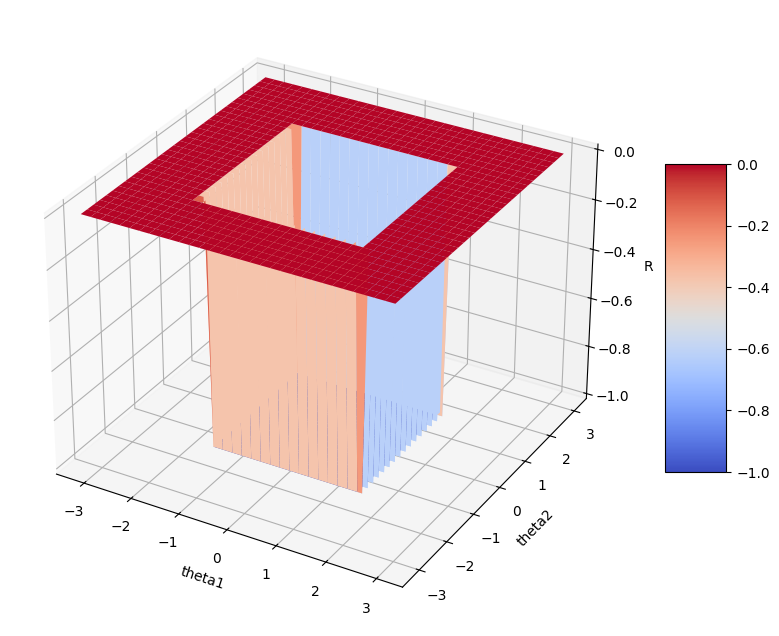

ImportError: cannot import name 'simulateAgent_2' from 'Eval' (d:\ASUS\Trí tuệ nhân tạo nâng cao - CS211\Inverse Reinforcement Learning\Inverse-Reinforcement-Learning\Eval.py)

In [23]:
# Tạo thư mục results trong cùng thư mục với file code
current_dir = os.getcwd()
save_dir = osp.join(current_dir, 'results')
os.makedirs(save_dir, exist_ok=True)

# Tạo dữ liệu để vẽ
xRange = np.arange(-np.pi, np.pi, 0.1)
yRange = np.arange(-np.pi, np.pi, 0.1)
toExternal = lambda x, y : toExternalStateRep([x, y, 0, 0])
RFn = compose(rewardFn, toExternal)

# Vẽ đồ thị
plotFunction(RFn, xRange, yRange, 'theta1', 'theta2', 'R')

# Tạo tên file với timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'recovered_{timestamp}.png'
save_path = osp.join(save_dir, filename)

# Lưu hình với chất lượng cao
plt.savefig(save_path, 
            dpi=300,           # độ phân giải cao
            bbox_inches='tight',  # cắt bỏ viền trắng thừa
            pad_inches=0.1,    # thêm padding nhỏ
            format='png')      # định dạng file

# Hiển thị đồ thị
plt.show()
from Eval import simulateAgent_2
# Chạy mô phỏng
simulateAgent_2(agent, render=True)
# video_display, steps = simulateAgentFile(agent)